In [1]:
import ROOT
import numpy as np
import pandas as pd

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.cc","k")

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.cc","k")

Welcome to JupyROOT 6.28/00


In [2]:
def getNumVarsFromCode(code):
    nVars = 0
    while(code > 0):
        nVars += int(code%2)
        code = int(code/2)
    return nVars


def getTotalNumVars(modelName):
    splitted = modelName.split("_")
    numVars = getNumVarsFromCode(int(splitted[1].replace("df", "")))
    numVars += getNumVarsFromCode(int(splitted[2].replace("dl", "")))
    numVars += len(splitted) - 3
    if "opt" in modelName:
        numVars -= 1
    return numVars

In [3]:
modelName="BDTG_df15_dl3684_v0_v1_opt10329"
channel="phi"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScalePhi0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScalePhi0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScalePhi1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScalePhi1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScalePhi2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScalePhi2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScalePhi0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

128.32333333333332
1.0081250000000002 629.0
440.30000000000007


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2


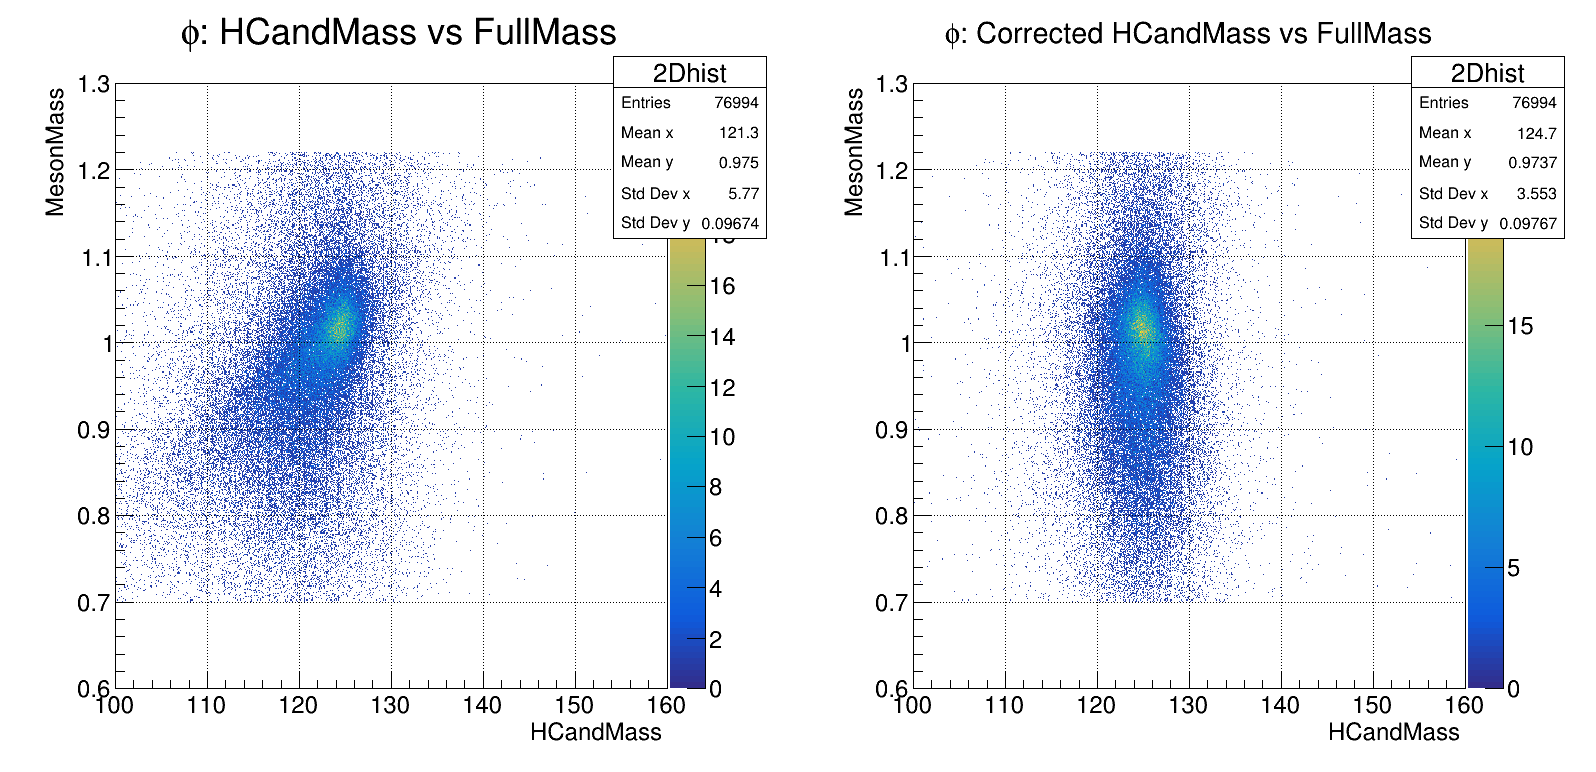

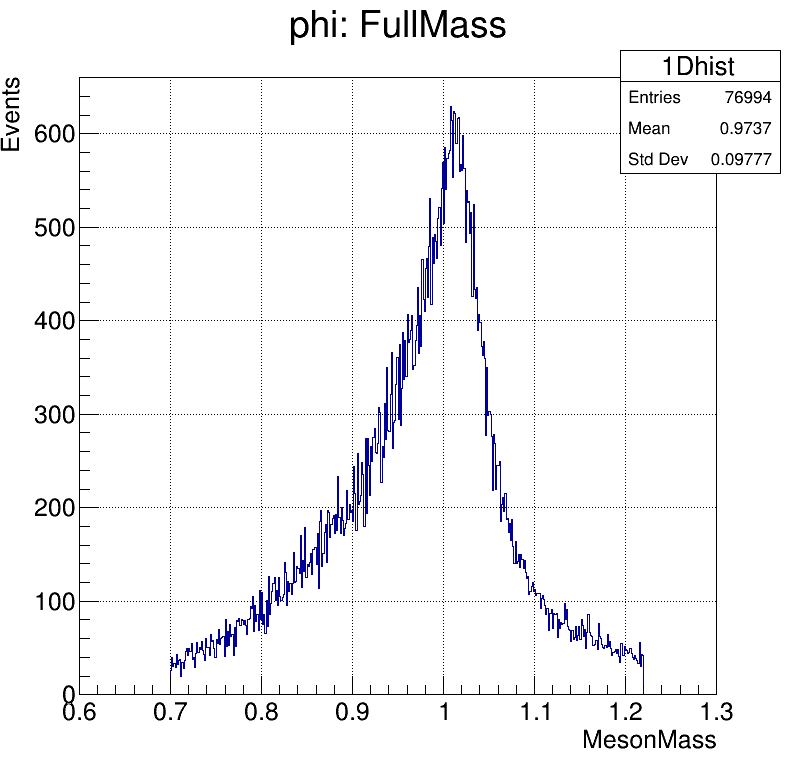

In [6]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 600, 100, 160, 0.6, 1.3
nbinsMeson = 560

p = canvas.cd(1)

h1 = dfSGN0.Histo2D(("2Dhist", "#{channel}: HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass", "goodMeson_mass").GetValue()
h1.Add(dfSGN1.Histo2D(("2Dhist", "#{channel}: HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass", "goodMeson_mass").GetValue())
h1.Add(dfSGN2.Histo2D(("2Dhist", "#{channel}: HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass", "goodMeson_mass").GetValue())

h1.GetXaxis().SetTitle("HCandMass")
h1.GetYaxis().SetTitle("MesonMass")
h1.GetZaxis().SetTitle("Events")
p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)

h1.SetContour(100)
h1.Draw("colz")
p.SetGrid()


p = canvas.cd(2)

h1Pred = dfSGN0.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue()
h1Pred.Add(dfSGN1.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue())
h1Pred.Add(dfSGN2.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue())

h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")
p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

canvas.Draw()


canvas2 = ROOT.TCanvas("canvas2", "canvas2", 800, 800)

hMass = dfSGN0.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbinsMeson, ylow, yhigh), "goodMeson_mass").GetValue()
hMass.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbinsMeson, ylow, yhigh), "goodMeson_mass").GetValue())
hMass.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbinsMeson, ylow, yhigh), "goodMeson_mass").GetValue())
hMass.Draw()
hMass.GetXaxis().SetTitle("MesonMass")
hMass.GetYaxis().SetTitle("Events")
canvas2.SetGrid()

canvas2.Draw()

inte = hMass.Integral(hMass.FindBin(ylow), hMass.FindBin(yhigh))/nbins
print(inte)

maxBin = hMass.GetMaximumBin()
xMax, yMax = hMass.GetBinCenter(maxBin), hMass.GetBinContent(maxBin)
print(xMax, yMax)
print((yhigh - ylow)*yMax)

In [5]:
modelName="BDTG_df15_dl3684_v0_v1_opt11264"
channel="omega"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScaleOmega0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScaleOmega0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleOmega1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScaleOmega1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleOmega2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScaleOmega2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScaleOmega0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

258.50666666666666
0.779 1164.0
698.4000000000001


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2


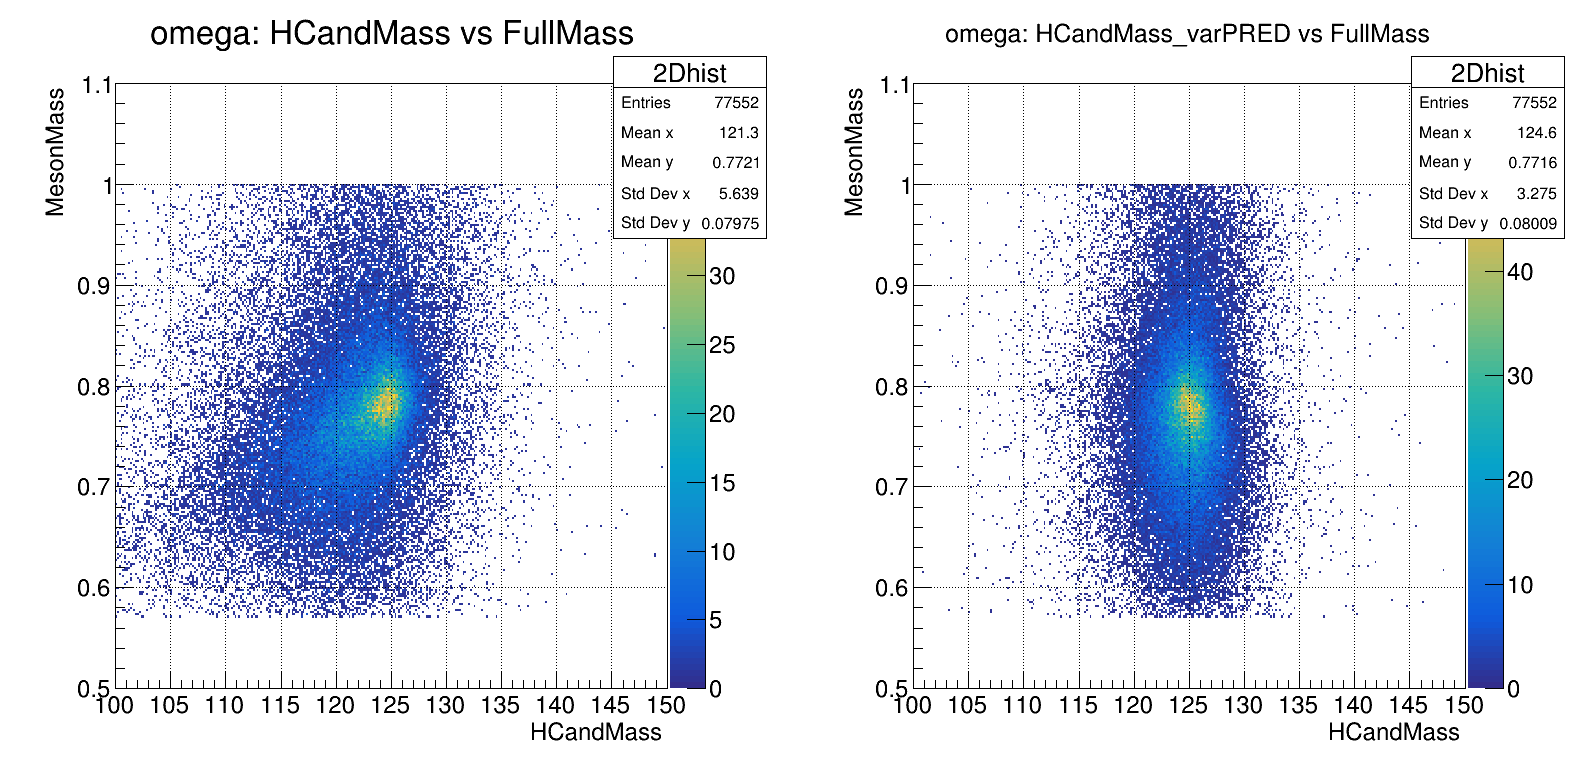

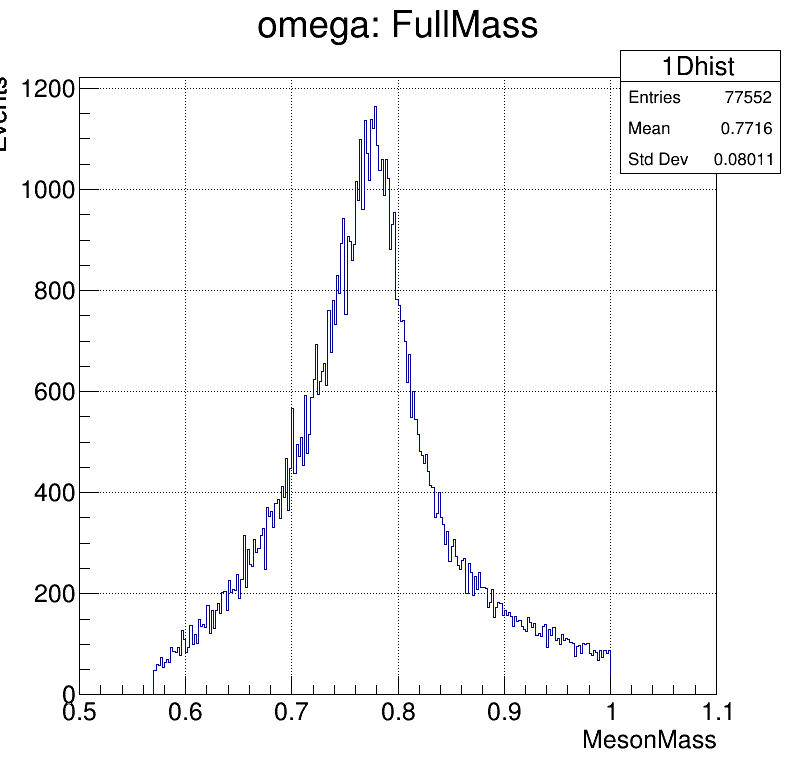

In [6]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 300, 100, 150, 0.5, 1.1

p = canvas.cd(1)

h1 = dfSGN0.Histo2D(("2Dhist", "{channel}: HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass", "goodMeson_mass").GetValue()
h1.Add(dfSGN1.Histo2D(("2Dhist", "{channel}: HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass", "goodMeson_mass").GetValue())
h1.Add(dfSGN2.Histo2D(("2Dhist", "{channel}: HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass", "goodMeson_mass").GetValue())

h1.GetXaxis().SetTitle("HCandMass")
h1.GetYaxis().SetTitle("MesonMass")
h1.GetZaxis().SetTitle("Events")
p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)

h1.SetContour(100)
h1.Draw("colz")
p.SetGrid()


p = canvas.cd(2)

h1Pred = dfSGN0.Histo2D(("2Dhist", "{channel}: HCandMass_varPRED vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue()
h1Pred.Add(dfSGN1.Histo2D(("2Dhist", "{channel}: HCandMass_varPRED vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue())
h1Pred.Add(dfSGN2.Histo2D(("2Dhist", "{channel}: HCandMass_varPRED vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue())

h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")
p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

canvas.Draw()

canvas2 = ROOT.TCanvas("canvas2", "canvas2", 800, 800)

hMass = dfSGN0.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbins, ylow, yhigh), "goodMeson_mass").GetValue()
hMass.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbins, ylow, yhigh), "goodMeson_mass").GetValue())
hMass.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbins, ylow, yhigh), "goodMeson_mass").GetValue())
hMass.Draw()
hMass.GetXaxis().SetTitle("MesonMass")
hMass.GetYaxis().SetTitle("Events")
canvas2.SetGrid()

canvas2.Draw()

inte = hMass.Integral(hMass.FindBin(ylow), hMass.FindBin(yhigh))/nbins
print(inte)

maxBin = hMass.GetMaximumBin()
xMax, yMax = hMass.GetBinCenter(maxBin), hMass.GetBinContent(maxBin)
print(xMax, yMax)
print((yhigh - ylow)*yMax)

In [7]:
modelName="BDTG_df7_dl3684_v0_v1_opt12167"
channel="d0star"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScaleD0Star0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScaleD0Star0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleD0Star1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScaleD0Star1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleD0Star2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScaleD0Star2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScaleD0Star0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

296.65
1.8620833333333333 1913.0
478.25


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2


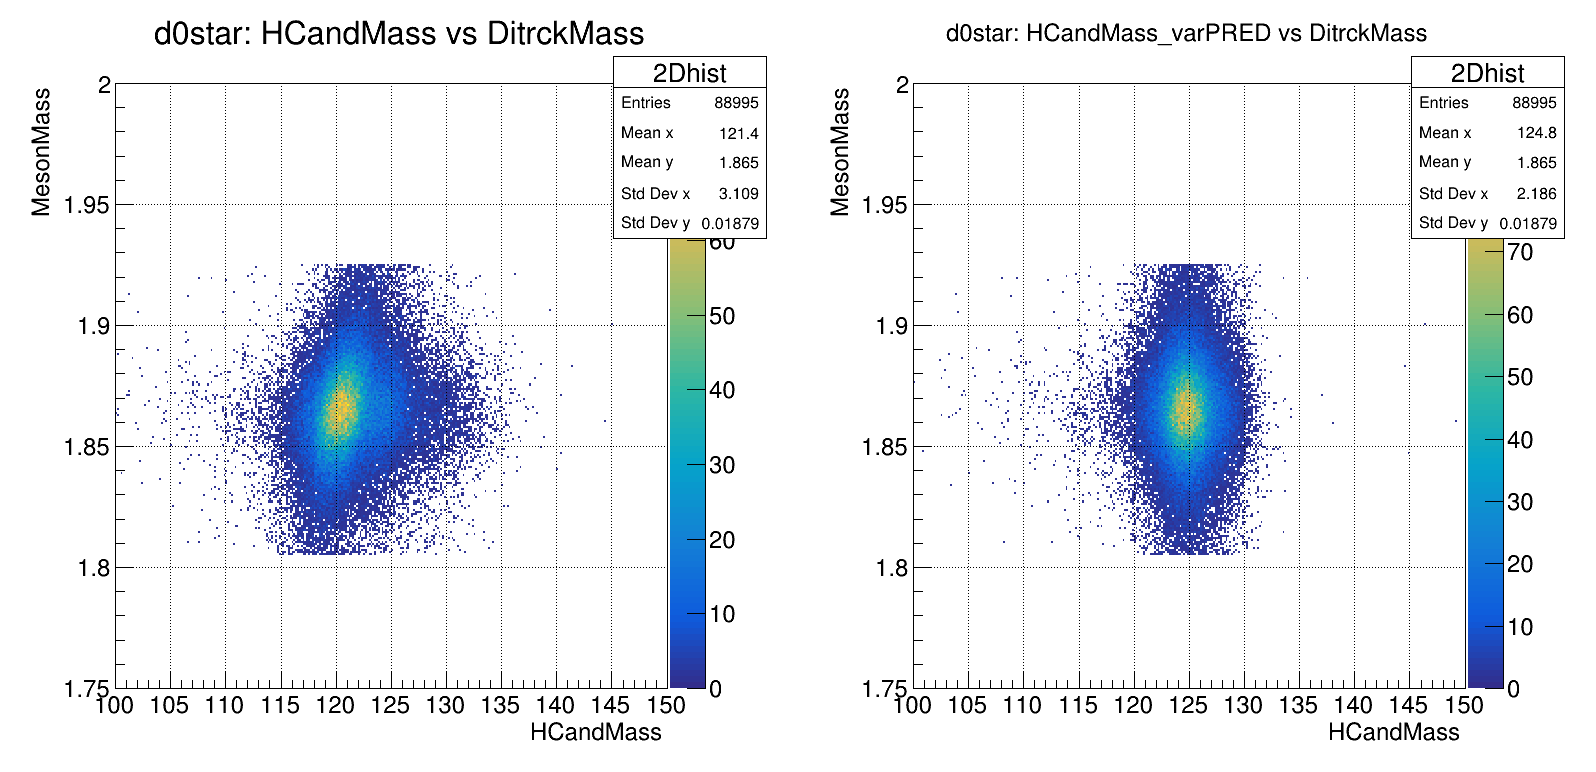

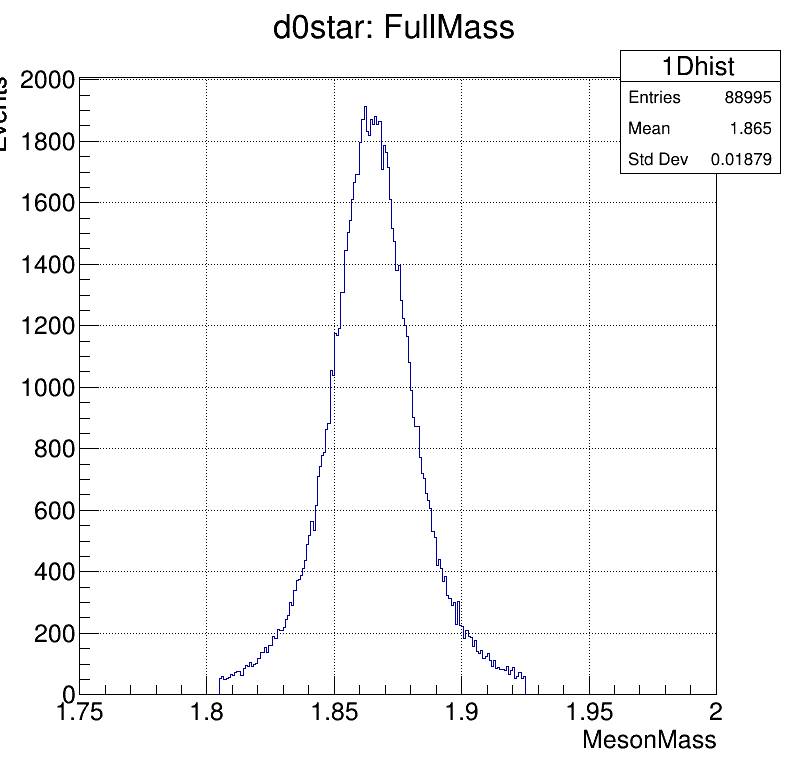

In [8]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 300, 100, 150, 1.75, 2.0

p = canvas.cd(1)

h1 = dfSGN0.Histo2D(("2Dhist", "{channel}: HCandMass vs DitrckMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass", "goodMeson_ditrk_mass").GetValue()
h1.Add(dfSGN1.Histo2D(("2Dhist", "{channel}: HCandMass vs DitrckMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass", "goodMeson_ditrk_mass").GetValue())
h1.Add(dfSGN2.Histo2D(("2Dhist", "{channel}: HCandMass vs DitrckMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass", "goodMeson_ditrk_mass").GetValue())

h1.GetXaxis().SetTitle("HCandMass")
h1.GetYaxis().SetTitle("MesonMass")
h1.GetZaxis().SetTitle("Events")
p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)

h1.SetContour(100)
h1.Draw("colz")
p.SetGrid()


p = canvas.cd(2)

h1Pred = dfSGN0.Histo2D(("2Dhist", "{channel}: HCandMass_varPRED vs DitrckMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass_varPRED", "goodMeson_ditrk_mass").GetValue()
h1Pred.Add(dfSGN1.Histo2D(("2Dhist", "{channel}: HCandMass_varPRED vs DitrckMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass_varPRED", "goodMeson_ditrk_mass").GetValue())
h1Pred.Add(dfSGN2.Histo2D(("2Dhist", "{channel}: HCandMass_varPRED vs DitrckMass".format(channel=channel), nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass_varPRED", "goodMeson_ditrk_mass").GetValue())

h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")
p.SetRightMargin(0.15)
p.SetLeftMargin(0.13)

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

canvas.Draw()

canvas2 = ROOT.TCanvas("canvas2", "canvas2", 800, 800)

hMass = dfSGN0.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbins, ylow, yhigh), "goodMeson_ditrk_mass").GetValue()
hMass.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbins, ylow, yhigh), "goodMeson_ditrk_mass").GetValue())
hMass.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: FullMass".format(channel=channel), nbins, ylow, yhigh), "goodMeson_ditrk_mass").GetValue())
hMass.Draw()
hMass.GetXaxis().SetTitle("MesonMass")
hMass.GetYaxis().SetTitle("Events")
canvas2.SetGrid()

canvas2.Draw()

inte = hMass.Integral(hMass.FindBin(ylow), hMass.FindBin(yhigh))/nbins
print(inte)

maxBin = hMass.GetMaximumBin()
xMax, yMax = hMass.GetBinCenter(maxBin), hMass.GetBinContent(maxBin)
print(xMax, yMax)
print((yhigh - ylow)*yMax)